In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import poisson

AttributeError: module 'numpy' has no attribute 'testing'

In [ ]:
# CONSTANT ANTIBIOTIC CONCENTRATION CONSTANTS WITH PERSISTENCE
# PARAMETERS FOR AMPICILLIN/E.COLI
MIC = 1.0 # ug/mL
MIC_r = 5.0 # ug/mL
MDK = 3.3 # assumed to be 1 for sus, so must be greater than 1
k = 0.75
min_growth = -3.0
max_growth_s = 0.96
max_growth_r = 0.75

# MUTATION RATE
wt_mu0 = 2.15*10**-10 # mutations per site per cell division
# wt_muslope = 7.46*10**-9 # mutation rate per site per cell division/ug/mL

# SIMULATION
T = 500
dt = 0.01
t = np.arange(0,T,dt)
r_initial = 0
s_initial = 100000
t_initial = 0
p_initial = 0
r = [r_initial]*len(t)
s = [s_initial]*len(t)
tol = [t_initial]*len(t)
p = [p_initial]*len(t)
tolr = [0]*len(t)
totaltol = [0]*len(t)
totalr = [0]*len(t)
t_lag = 0
K = 10**7
mean_sr = [0]*len(t)
mean_tr = [0]*len(t)
mean_st = [0]*len(t)
mean_sp = [0]*len(t)
mean_ps = [0]*len(t)
mean_pr = [0]*len(t)

# ANTIBIOTIC ADMINISTRATION
duration = 4.5
initial_conc = 50


def conc(time):
    if time%24 > duration:
        conc = 0
    else:
        conc = initial_conc
    return conc

concentration = [conc(time) for time in t]
plt.figure()
plt.plot(t,concentration)
plt.xlabel("time (hr)")
plt.ylabel("antibiotic concentration (ug/mL)")
plt.show()

In [ ]:
x = np.arange(0,10,0.01)
y = []
for i in x:
    y.append(np.exp(max_growth_s*i))
r = [1]*len(x)
for i in range(1,len(x)-1):
    r[i+1] = r[i] + np.random.poisson(r[i]*max_growth_s*0.01)
plt.plot(x,y)
plt.plot(x,r)
plt.yscale("log")

In [ ]:
# TOLERANCE AND PERSISTENCE

def growth_rate_r(c):
    return max_growth_r
def growth_rate_s(c):
    return max_growth_s 
def growth_rate_t(c):
    return max_growth_s/MDK
def growth_rate_tolr(c):
    return max_growth_s/MDK
def death_rate_r(c):
    return (((max_growth_r - min_growth)*((c/MIC_r)**k))/(((c/MIC_r)**k)-(min_growth/max_growth_r)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def death_rate_t(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))/MDK
def death_rate_tolr(c):
    return (((max_growth_r - min_growth)*(c/MIC_r)**k)/(((c/MIC_r)**k)-(min_growth/max_growth_r)))/MDK
def mut_frequency(c):
    mut = wt_mu0
    return mut
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation_tp(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
    # 1/generation time
        g_r = growth_rate_r(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r = death_rate_r(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        g_t = growth_rate_t(conc(i*dt))
        d_t = death_rate_t(conc(i*dt))
        g_tolr = growth_rate_tolr(conc(i*dt))
        d_tolr = death_rate_tolr(conc(i*dt))
        N = r[i] + s[i] + tol[i] + tolr[i] + p[i]
        mean_tr[i] = abs(10**4*dt*(mut_frequency(conc(i*dt))*(tol[i]))*g_t*(1-N/K))
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt))*s[i])*g_s*(1-N/K)) # average probability of mutations in time dt
        mean_st[i] = abs(50*dt*(mut_frequency(conc(i*dt))*s[i])*g_s*(1-N/K))
        mean_sp[i] = abs(dt*s[i]*0.0001*(N/K)) # conversion to persistent bacteria depends on population density
        mean_ps[i] = abs(dt*p[i]*0.0001*(N/K))
        mean_pr[i] = abs(10**4*dt*(mut_frequency(conc(i*dt))*p[i]))
# change in population from regular growth
        if r[i]*(1-(N/K))*(g_r*dt) > 0: 
            if (np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt)) > -r[i] and r[i] >= 1: 
                r[i+1] = (r[i] + np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt))
            else:
                r[i+1] = 0
        elif d_r*r[i]*dt > 0:
            r[i+1] = r[i] - np.random.poisson(d_r*r[i]*dt)
        else:
            r[i+1] = r[i]
        if tolr[i]*(1-(N/K))*(g_tolr*dt) > 0: 
            if (np.random.poisson(tolr[i]*(1-(N/K))*(g_tolr*dt)) - np.random.poisson(d_tolr*tolr[i]*dt)) > -tolr[i] and tolr[i] >= 1:
                tolr[i+1] = tolr[i] + np.random.poisson(tolr[i]*(1-(N/K))*(g_tolr*dt)) - np.random.poisson(d_tolr*tolr[i]*dt)
            else:
                tolr[i+1] = 0
        elif d_tolr*tolr[i]*dt:
            tolr[i+1] = tolr[i] - np.random.poisson(d_tolr*tolr[i]*dt)
        else:
            tolr[i+1] = tolr[i]
        if tol[i]*(1-(N/K))*(g_t*dt) > 0:
            if i>t_lag and (np.random.poisson(tol[i]*(1-(N/K))*(g_t*dt)) - np.random.poisson(abs(d_t*tol[i]*dt))) > -tol[i] and tol[i] >= 1:
                tol[i+1] = tol[i] + np.random.poisson(tol[i]*(1-(N/K))*(g_t*dt)) - np.random.poisson(abs(d_t*tol[i]*dt))
            elif i<t_lag and tol[i] > 1:
                tol[i+1] = tol[i]
            else:
                tol[i+1] = 0
        elif d_t*t[i]*dt > 0:
            if i<t_lag:
                tol[i+1] = tol[i]
            else:
                tol[i+1] = tol[i] - np.random.poisson(d_t*tol[i]*dt)
        else:
            tol[i+1] = tol[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i]
        p[i+1] = p[i] + 0*p[i] # no growth or death for persistent bacteria
# change in population from mutations 
        s[i+1] += (np.random.poisson(mean_ps[i]) - np.random.poisson(mean_sr[i]) - np.random.poisson(mean_st[i]) - np.random.poisson(mean_sp[i]))
        r[i+1] += (np.random.poisson(mean_sr[i]) + np.random.poisson(mean_pr[i]))
        tol[i+1] += (-np.random.poisson(mean_tr[i]) + np.random.poisson(mean_st[i]))
        tolr[i+1] += np.random.poisson(mean_tr[i])
        p[i+1] += (np.random.poisson(mean_sp[i]) - np.random.poisson(mean_ps[i]))
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve models
simulation(20)

# plot results
plt.figure()
plt.plot(t,r,label="resistant")
plt.plot(t,s,label="susceptible")
plt.plot(t,tol,label="tolerant")
plt.plot(t,tolr,label="tolerant+resistant")
plt.plot(t,p,label="persistent")
plt.xlabel('time (hours)')
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
def present_probability_stp(runs):
    count = 0
    for q in range(runs):
        simulation_tp(q)
        if s[40000] > 10:
            count += 1
    return count
def present_probability_rtp(runs):
    count = 0
    for q in range(runs):
        simulation_tp(q)
        if r[40000] > 10:
            count += 1
    return count
print(present_probability_rtp(100))
print(present_probability_stp(100))

In [4]:
# TOLERANCE NO PERSISTENCE

def growth_rate_r(c):
    return max_growth_r
def growth_rate_s(c):
    return max_growth_s 
def growth_rate_t(c):
    return max_growth_s/MDK
def growth_rate_tolr(c):
    return max_growth_s/MDK
def death_rate_r(c):
    return (((max_growth_r - min_growth)*((c/MIC_r)**k))/(((c/MIC_r)**k)-(min_growth/max_growth_r)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def death_rate_t(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))/MDK
def death_rate_tolr(c):
    return (((max_growth_r - min_growth)*(c/MIC_r)**k)/(((c/MIC_r)**k)-(min_growth/max_growth_r)))/MDK
def mut_frequency(c):
    mut = wt_mu0
    return mut
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation_t(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
    # 1/generation time
        g_r = growth_rate_r(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r = death_rate_r(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        g_t = growth_rate_t(conc(i*dt))
        d_t = death_rate_t(conc(i*dt))
        g_tolr = growth_rate_tolr(conc(i*dt))
        d_tolr = death_rate_tolr(conc(i*dt))
        N = r[i] + s[i] + tol[i] + tolr[i] + p[i]
        mean_tr[i] = abs(10**4*dt*(mut_frequency(conc(i*dt))*(tol[i]))*g_t*(1-N/K))
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt))*s[i])*g_s*(1-N/K)) # average probability of mutations in time dt
        mean_st[i] = abs(50*dt*(mut_frequency(conc(i*dt))*s[i])*g_s*(1-N/K))
# change in population from regular growth
        if r[i]*(1-(N/K))*(g_r*dt) > 0: 
            if r[i]*(1-(N/K))*(g_r*dt) - d_r*r[i]*dt > -r[i] and r[i] >= 1: 
                r[i+1] = (r[i] + np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt))
            else:
                r[i+1] = 0
        elif d_r*r[i]*dt > 0:
            r[i+1] = r[i] - np.random.poisson(d_r*r[i]*dt)
        else:
            r[i+1] = r[i]
        if tolr[i]*(1-(N/K))*(g_tolr*dt) > 0: 
            if (tolr[i]*(1-(N/K))*(g_tolr*dt)) - d_tolr*tolr[i]*dt > -tolr[i] and tolr[i] >= 1:
                tolr[i+1] = tolr[i] + np.random.poisson(tolr[i]*(1-(N/K))*(g_tolr*dt)) - np.random.poisson(d_tolr*tolr[i]*dt)
            else:
                tolr[i+1] = 0
        elif d_tolr*tolr[i]*dt > 0:
            tolr[i+1] = tolr[i] - np.random.poisson(d_tolr*tolr[i]*dt)
        else:
            tolr[i+1] = tolr[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i]
        if i*dt>t_lag:
            if tol[i]*(1-(N/K))*(g_t*dt) > 0:
                if (tol[i]*(1-(N/K))*(g_t*dt)) - d_t*tol[i]*dt > -tol[i] and tol[i] >= 1:
                    tol[i+1] = tol[i] + np.random.poisson(tol[i]*(1-(N/K))*(g_t*dt)) - np.random.poisson(d_t*tol[i]*dt)
                else:
                    tol[i+1] = 0
            elif d_t*tol[i]*dt > 0:
                tol[i+1] = tol[i] - np.random.poisson(d_t*tol[i]*dt)
            else:
                tol[i+1] = tol[i]
        else:
            tol[i+1] = tol[i]
# change in population from mutations 
        s[i+1] += (- np.random.poisson(mean_sr[i]) - np.random.poisson(mean_st[i]))
        r[i+1] += (np.random.poisson(mean_sr[i]))
        tol[i+1] += (-np.random.poisson(mean_tr[i]) + np.random.poisson(mean_st[i]))
        tolr[i+1] += np.random.poisson(mean_tr[i])
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve models
simulation_t(32)

# plot results
plt.figure()
plt.plot(t,r,label="resistant")
plt.plot(t,s,label="susceptible")
plt.plot(t,tol,label="tolerant")
plt.plot(t,tolr,label="tolerant+resistant")
# plt.plot(t,p,label="persistent")
plt.xlabel('time (hours)')
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend()
plt.title("Resistant Background without Persistence")
plt.show()

NameError: name 'np' is not defined

In [171]:
def present_probability_st(runs):
    count = 0
    for q in range(runs):
        simulation_t(q)
        if s[40000] > 10:
            count += 1
    return count
def present_probability_rt(runs):
    count = 0
    for q in range(runs):
        simulation_t(q)
        if r[40000] > 10:
            count += 1
    return count

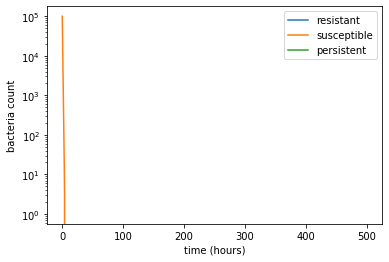

In [172]:
# PERSISTENCE NO TOLERANCE

def growth_rate_r(c):
    return max_growth_r
def growth_rate_s(c):
    return max_growth_s 
def growth_rate_t(c):
    return max_growth_s/MDK
def growth_rate_tolr(c):
    return max_growth_s/MDK
def death_rate_r(c):
    return (((max_growth_r - min_growth)*((c/MIC_r)**k))/(((c/MIC_r)**k)-(min_growth/max_growth_r)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def death_rate_t(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))/MDK
def death_rate_tolr(c):
    return (((max_growth_r - min_growth)*(c/MIC_r)**k)/(((c/MIC_r)**k)-(min_growth/max_growth_r)))/MDK
def mut_frequency(c):
    mut = wt_mu0 + (wt_muslope*c)
    return mut
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation_p(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
    # 1/generation time
        g_r = growth_rate_r(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r = death_rate_r(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        g_t = growth_rate_t(conc(i*dt))
        d_t = death_rate_t(conc(i*dt))
        g_tolr = growth_rate_tolr(conc(i*dt))
        d_tolr = death_rate_tolr(conc(i*dt))
        N = r[i] + s[i] + tol[i] + tolr[i] + p[i]
#         mean_tr[i] = abs(10**4*dt*(mut_frequency(conc(i*dt))*(tol[i]))*g_t)
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt))*s[i])*g_s) # average probability of mutations in time dt
#         mean_st[i] = abs(50*dt*(mut_frequency(conc(i*dt))*s[i])*g_s)
        mean_sp[i] = abs(dt*s[i]*0.0001*(N/K)) # conversion to persistent bacteria depends on population density
        mean_ps[i] = abs(dt*p[i]*0.0001*(N/K))
        mean_pr[i] = abs(10**4*dt*(mut_frequency(conc(i*dt))*p[i]))
# change in population from regular growth
        if r[i]*(1-(N/K))*(g_r*dt) > 0: 
            if (np.random.poisson(abs(r[i]*(1-(N/K))*(g_r*dt))) - np.random.poisson(d_r*r[i]*dt)) > -r[i] and r[i] >= 1: 
                r[i+1] = (r[i] + np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt))
            else:
                r[i+1] = 0
        elif d_r*r[i]*dt > 0:
            r[i+1] = r[i] - np.random.poisson(d_r*r[i]*dt)
        else:
            r[i+1] = r[i]
#         if tolr[i]*(1-(N/K))*(g_tolr*dt) > 0: 
#             if (np.random.poisson(tolr[i]*(1-(N/K))*(g_tolr*dt)) - np.random.poisson(d_tolr*tolr[i]*dt)) > -tolr[i] and tolr[i] >= 1:
#                 tolr[i+1] = tolr[i] + np.random.poisson(tolr[i]*(1-(N/K))*(g_tolr*dt)) - np.random.poisson(d_tolr*tolr[i]*dt)
#             else:
#                 tolr[i+1] = 0
#         elif d_tolr*tolr[i]*dt:
#             tolr[i+1] = tolr[i] - np.random.poisson(d_tolr*tolr[i]*dt)
#         else:
#             tolr[i+1] = tolr[i]
#         if tol[i]*(1-(N/K))*(g_t*dt) > 0:
#             if i>t_lag and (np.random.poisson(tol[i]*(1-(N/K))*(g_t*dt)) - np.random.poisson(abs(d_t*tol[i]*dt))) > -tol[i] and tol[i] >= 1:
#                 tol[i+1] = tol[i] + np.random.poisson(tol[i]*(1-(N/K))*(g_t*dt)) - np.random.poisson(abs(d_t*tol[i]*dt))
#             elif i<t_lag and tol[i] > 1:
#                 tol[i+1] = tol[i]
#             else:
#                 tol[i+1] = 0
#         elif d_t*t[i]*dt > 0:
#             if i<t_lag:
#                 tol[i+1] = tol[i]
#             else:
#                 tol[i+1] = tol[i] - np.random.poisson(d_t*tol[i]*dt)
#         else:
#             tol[i+1] = tol[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i]
        p[i+1] = p[i] + 0*p[i] # no growth or death for persistent bacteria
# change in population from mutations 
        s[i+1] += (np.random.poisson(mean_ps[i]) - np.random.poisson(mean_sr[i]) - np.random.poisson(mean_st[i]) - np.random.poisson(mean_sp[i]))
        r[i+1] += (np.random.poisson(mean_sr[i]) + np.random.poisson(mean_pr[i]))
#         tol[i+1] += (-np.random.poisson(mean_tr[i]) + np.random.poisson(mean_st[i]))
#         tolr[i+1] += np.random.poisson(mean_tr[i])
        p[i+1] += (np.random.poisson(mean_sp[i]) - np.random.poisson(mean_ps[i]))
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve models
simulation(23)

# plot results
plt.figure()
plt.plot(t,r,label="resistant")
plt.plot(t,s,label="susceptible")
# plt.plot(t,tol,label="tolerant")
# plt.plot(t,tolr,label="tolerant+resistant")
plt.plot(t,p,label="persistent")
plt.xlabel('time (hours)')
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend()
plt.show()

In [173]:
def present_probability_sp(runs):
    count = 0
    for q in range(runs):
        simulation_p(q)
        if s[40000] > 10:
            count += 1
    return count
def present_probability_rp(runs):
    count = 0
    for q in range(runs):
        simulation_p(q)
        if r[40000] > 10:
            count += 1
    return count

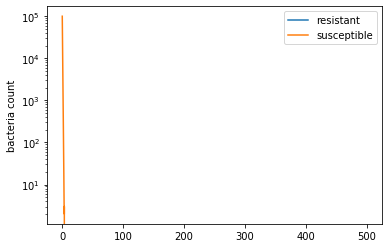

In [199]:
# NO PERSISTENCE NO TOLERANCE

def growth_rate_r(c):
    return max_growth_r
def growth_rate_s(c):
    return max_growth_s 
def death_rate_r(c):
    return (((max_growth_r - min_growth)*((c/MIC_r)**k))/(((c/MIC_r)**k)-(min_growth/max_growth_r)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def mut_frequency(c):
    mut = wt_mu0
    return mut
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation_(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
        g_r = growth_rate_r(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r = death_rate_r(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        N = r[i] + s[i]
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt))*s[i])*g_s*(1-N/K)) # average probability of mutations in time dt
        if r[i]*(1-(N/K))*(g_r*dt) > 0: 
            if (np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt)) > -r[i] and r[i] >= 1: 
                r[i+1] = (r[i] + np.random.poisson(r[i]*(1-(N/K))*(g_r*dt)) - np.random.poisson(d_r*r[i]*dt))
            else:
                r[i+1] = 0
        elif d_r*r[i]*dt > 0:
            r[i+1] = r[i] - np.random.poisson(d_r*r[i]*dt)
        else:
            r[i+1] = r[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i] 
        s[i+1] -= np.random.poisson(mean_sr[i])
        r[i+1] += (np.random.poisson(mean_sr[i]))
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve models
simulation(98)

# plot results
plt.figure()
plt.plot(t,r,label="resistant")
plt.plot(t,s,label="susceptible")
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend()
plt.show()

In [201]:
def present_probability_s(runs):
    count = 0
    for q in range(runs):
        simulation_(q)
        if s[40000] > 10:
            count += 1
    return count
def present_probability_r(runs):
    count = 0
    for q in range(runs):
        simulation_(q)
        if r[40000] > 10:
            count += 1
    return count
print(present_probability_s(100))
print(present_probability_r(100))


0
0


In [178]:
print(present_probability_stp(100))
print(present_probability_rtp(100))
print(present_probability_sp(100))
print(present_probability_rp(100))
print(present_probability_st(100))
print(present_probability_rt(100))
print(present_probability_s(100))
print(present_probability_r(100))

48
48


KeyboardInterrupt: 

|  | Susceptible | Resistant |
| --- | --- | --- |
| T+P | 48 | 48 |
| T |  |  |
| P |  |  |
| Neither |  |  |

SUSCEPTIBLE
Tolerance and Persistence: 48
Tolerance Only: 37
Persistence Only: 40
Neither Tolerance nor Persistence: 41